# Catch and Shoot Performance EDA and Model
In this notebook, I will explore the relationships of different player stats and their future catch and shoot expected value.  

Goals:
- Look for what stats might best predict catch and shoot expected value.
- Find the best model to make accurate predictions.

Conclusions: 
- Catch and shoot EV is mostly related to wide open shooting.
- How often they shoot (catch-and-shoot and pull-up shots are also important).
- Smaller players tend to do better as well (height and skinnyness).

## 0. Importing Libraries and Data

In [3]:
# Importing standard libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
# Importing SKlearn libraries
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, RFECV, f_regression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import regularizers
from keras.callbacks import EarlyStopping
# Importing created functions
from dictionaries import stat_types
from df_functions import use_history
from model_prep import corr_finder, data_split, feature_selection_corr, shift_data
from graphing import corr_plots, box_plots, graph_results

In [7]:
# Importing data
master_df = pd.read_csv('./data/master_df', index_col=0)

## 1. Create Train, Validate, and Test Sets
#### Create X and y

In [133]:
# Saving the data for all player seasons where they had at least 50 post-ups
post_index = master_df[(master_df['CATCH_SHOOT_FGA'] * master_df['GP']) >= 50].index
data = master_df.loc[post_index]

In [134]:
# Matching player data with the target data in the following year
data = shift_data(data, 'PLAYER_ID', ['CATCH_SHOOT_EV'])

In [135]:
# Setting up the initial X and y
y = data.loc[:, ['TARGET_CATCH_SHOOT_EV']]
X = data.drop(columns='TARGET_CATCH_SHOOT_EV')

#### Splitting X and y into train, validate, and test sets

In [136]:
# Creating the train, validate, and test sets for post-up expected value
X_train, X_validate, X_test, y_train, y_validate, y_test = data_split(X, y, 'CATCH_SHOOT_EV')

## 2. Determine Potential Features
- A lot of the stats are related to the rate and efficacy of shooting.
- We also see a negative correlation with stats related to bigger players (rebounding).

#### Finding correlated features

In [137]:
# Saving a list of possible numerical features
numeric_columns = list(data.dropna(axis=1).select_dtypes(['float', 'int']).columns)
numeric_columns.remove('TEAM_ID')
numeric_columns.remove('PLAYER_ID')
numeric_columns.remove('2018')

In [138]:
# Looking for features with the highest correlation with the target
corr_features = corr_finder(X_train[numeric_columns], y_train, .3, 10)

In [139]:
# Looking at the most correlated features with the target
corr_features

['CATCH_SHOOT_EV_WEIGHTED',
 'CATCH_SHOOT_EFG_PCT_WEIGHTED',
 'CATCH_SHOOT_EV',
 'CATCH_SHOOT_EFG_PCT',
 'CATCH_SHOOT_FG3_PCT_WEIGHTED',
 'CATCH_SHOOT_FG3M_WEIGHTED',
 'OREB_CHANCES_PER_MIN_WEIGHTED',
 'OREB_CHANCES_PER_MIN',
 'VERY_OPEN_FG3M',
 'CATCH_SHOOT_FG3M']

In [140]:
# Finding the most correlated features that are not correlated with each other
corr_features = feature_selection_corr(X_train[numeric_columns], y_train['TARGET_CATCH_SHOOT_EV'], alpha=.4)

#### Graphing correlated features

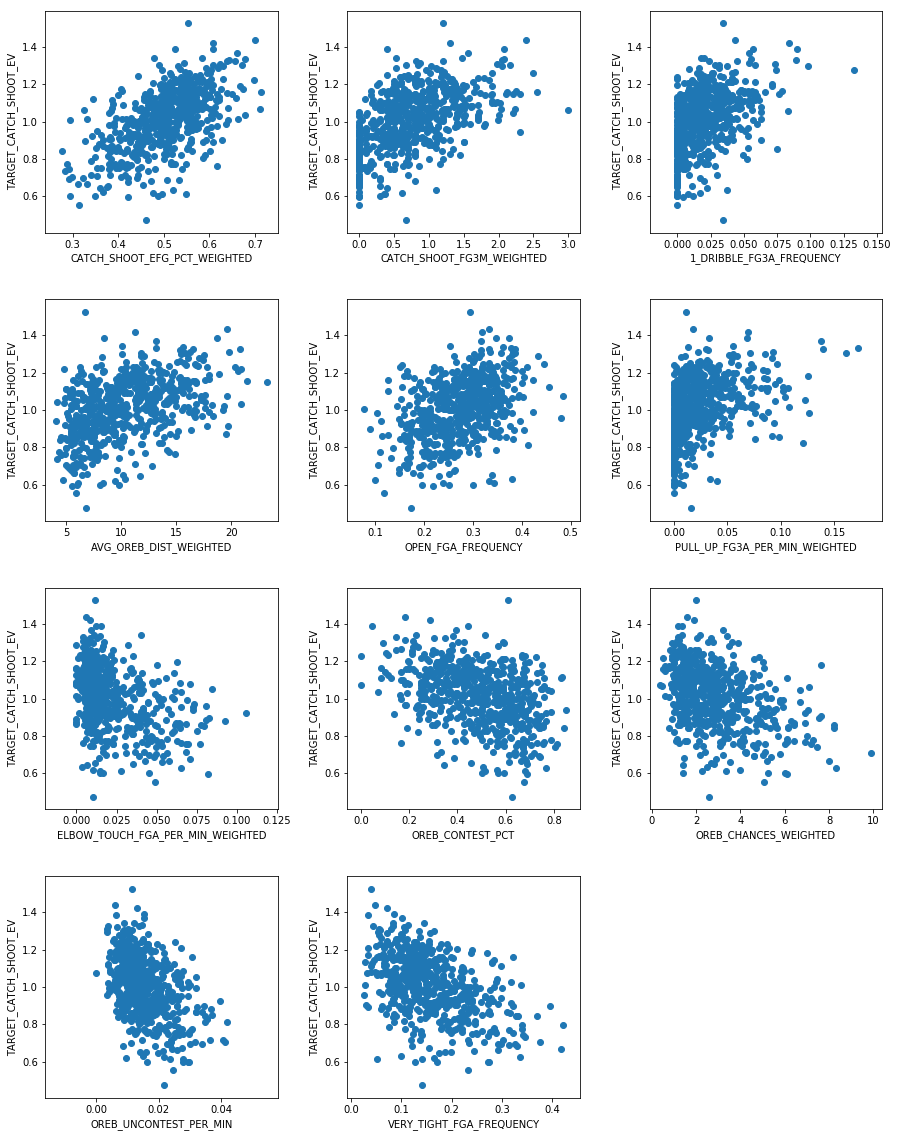

In [141]:
# Plotting those features
corr_plots(X_train, y_train, corr_features);

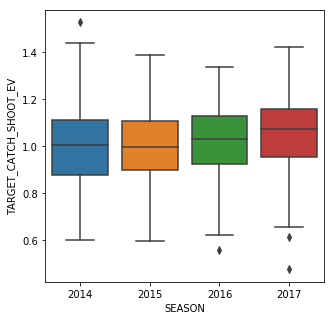

In [142]:
box_plots(X_train, y_train, ['SEASON'], cols=1)

#### Looking at driving and age

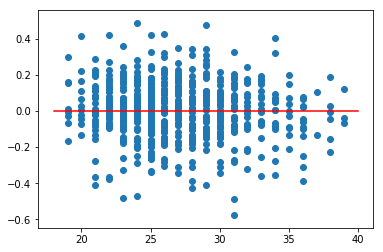

In [143]:
plt.scatter(X_train['AGE'], y_train['TARGET_CATCH_SHOOT_EV'] - X_train['CATCH_SHOOT_EV'])
plt.plot([18,40], [0,0], color='r');

## 3. Modeling

#### RFECV
- Used significantly more features than any of the previous model (for other targets).
- Score was high compared to past model (for other targets).

In [144]:
# Using recursive feature elimination to attempt to select features for the model
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True)
rfecv = RFECV(estimator=model, step=1, cv=kfolds)
rfecv.fit(X_train[numeric_columns], y_train.iloc[:,0])
rfecv.n_features_

33

In [145]:
# Checking which features were selected
X_train[numeric_columns].columns[rfecv.get_support(indices=True)]

Index(['SEASON', 'OREB_CHANCE_PCT', 'OREB_CHANCE_PCT_ADJ',
       'OPEN_FGA_FREQUENCY', 'OPEN_FG2A_FREQUENCY', 'OPEN_FG3A_FREQUENCY',
       'DIST_MILES_PER_MIN', 'OREB_CHANCE_DEFER_PER_MIN',
       'DREB_CHANCE_DEFER_PER_MIN', 'TIGHT_FGA_PER_MIN', 'TIGHT_FG2A_PER_MIN',
       'TIGHT_FG3A_PER_MIN', 'OPEN_FGM_PER_MIN', 'OPEN_FGA_PER_MIN',
       'OPEN_FG2M_PER_MIN', 'OPEN_FG2A_PER_MIN', 'OPEN_FG3M_PER_MIN',
       'OPEN_FG3A_PER_MIN', '1_DRIBBLE_FGM_PER_MIN', '1_DRIBBLE_FG2M_PER_MIN',
       'OREB_CHANCE_PCT_WEIGHTED', 'OREB_CHANCE_PCT_ADJ_WEIGHTED',
       'DIST_MILES_PER_MIN_WEIGHTED', 'DIST_MILES_OFF_PER_MIN_WEIGHTED',
       'DIST_MILES_DEF_PER_MIN_WEIGHTED', 'OREB_CHANCE_DEFER_PER_MIN_WEIGHTED',
       'DREB_CHANCE_DEFER_PER_MIN_WEIGHTED',
       'PAINT_TOUCH_FGM_PER_MIN_WEIGHTED', 'PAINT_TOUCH_FTA_PER_MIN_WEIGHTED',
       'PAINT_TOUCH_PTS_PER_MIN_WEIGHTED', '2015', '2016', '2017'],
      dtype='object')

In [146]:
# Checking out the score with the validation data
rfecv.score(X_validate[numeric_columns], y_validate)

0.3688185899759504

#### K BEST
- Surprisingly, the scores got worse as the number of features increased.
- Just using the current season driving rate seemed to get the best score.

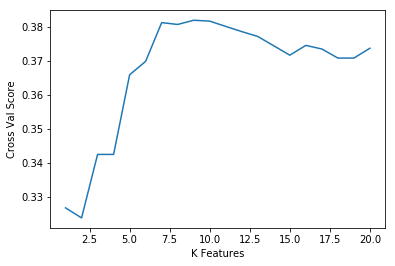

In [151]:
# Looping to select the best k for select k best feature selection
k_scores = []
for k in range(1, 21):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending cross val scores for those features
    model = LinearRegression()
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    k_scores.append(cross_val_score(model, X_train[model_features], y_train, cv=kfolds).mean())
    
plt.plot(range(1, 21), k_scores)
plt.xlabel('K Features')
plt.ylabel('Cross Val Score');

7  Feature Cross Val Scores:  [0.405092   0.40300716 0.47438358 0.26483244 0.35886168]
8  Feature Cross Val Scores:  [0.40508255 0.40342699 0.47418108 0.26249652 0.35832565]
9  Feature Cross Val Scores:  [0.40549809 0.40715638 0.47945157 0.25762434 0.35997199]
10  Feature Cross Val Scores:  [0.4008266  0.40897257 0.47944074 0.25967988 0.35950148]
11  Feature Cross Val Scores:  [0.40263874 0.40326823 0.47419423 0.25909677 0.36141813]
12  Feature Cross Val Scores:  [0.40069718 0.40279999 0.47179756 0.25976635 0.35793654]
13  Feature Cross Val Scores:  [0.39969695 0.40029158 0.47058233 0.25869974 0.35653791]
14  Feature Cross Val Scores:  [0.39022068 0.39675422 0.47087763 0.25724803 0.35696323]
15  Feature Cross Val Scores:  [0.38534529 0.39346833 0.47124959 0.2521116  0.35608539]
16  Feature Cross Val Scores:  [0.3973012  0.37320122 0.47756459 0.26164594 0.36295948]
17  Feature Cross Val Scores:  [0.38164675 0.37321273 0.4801897  0.26611627 0.36620013]
18  Feature Cross Val Scores:  [0.3

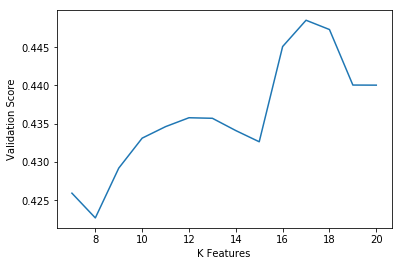

In [152]:
# Checking out 5 - 10 features
k_scores = []
for k in range(7, 21):
    
    # Finding the best features for a given k
    k_best = SelectKBest(f_regression, k=k)
    k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
    model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
    
    # Appending the validation scores
    model = LinearRegression()
    model.fit(X_train[model_features], y_train)
    k_scores.append(model.score(X_validate[model_features], y_validate))
    
    # Printing out the cross val scores
    kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
    print(k, ' Feature Cross Val Scores: ', cross_val_score(model, X_train[model_features], y_train, cv=kfolds))
    
# Graphing the validations scores
plt.plot(range(7, 21), k_scores)
plt.xlabel('K Features')
plt.ylabel('Validation Score');

In [153]:
# Printing out the scores with 17 features
k_best = SelectKBest(f_regression, k=17)
k_best.fit(X_train[numeric_columns], y_train.iloc[:,0])
model_features = list(X_train[numeric_columns].columns[k_best.get_support()])
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.4485326124199879

In [154]:
# Printing the model features
model_features

['CATCH_SHOOT_FG3M',
 'CATCH_SHOOT_FG3_PCT',
 'CATCH_SHOOT_EFG_PCT',
 'VERY_TIGHT_FG2A_FREQUENCY',
 'VERY_OPEN_FG3M',
 'CATCH_SHOOT_EV',
 'OREB_PER_MIN',
 'OREB_CHANCES_PER_MIN',
 'PAINT_TOUCHES_PER_MIN',
 'OPEN_FG3M_PER_MIN',
 'CATCH_SHOOT_FG3M_WEIGHTED',
 'CATCH_SHOOT_FG3_PCT_WEIGHTED',
 'CATCH_SHOOT_EFG_PCT_WEIGHTED',
 'CATCH_SHOOT_EV_WEIGHTED',
 'OREB_PER_MIN_WEIGHTED',
 'OREB_CHANCES_PER_MIN_WEIGHTED',
 'PAINT_TOUCHES_PER_MIN_WEIGHTED']

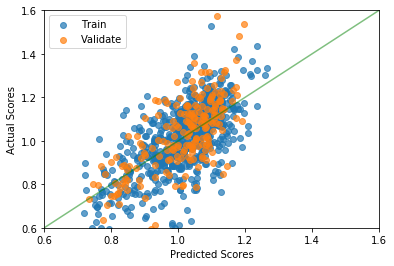

In [155]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=1.6,
              axis_min=.6)

#### PCA
- The model does poorly compared to the previous ones.
- The elbow method pointed to using 2 features.

In [195]:
# Fitting PCA and checking the explained variance
pca = PCA(n_components=15)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[numeric_columns])
X_validate_scaled = scaler.transform(X_validate[numeric_columns])
pca.fit(X_train_scaled)
explained_var = pca.explained_variance_ratio_
explained_var

array([0.29418903, 0.19545344, 0.07113116, 0.04307597, 0.03034734,
       0.02593903, 0.02120976, 0.01893978, 0.01591204, 0.01538156,
       0.01363543, 0.01258777, 0.01007266, 0.00921863, 0.00917278])

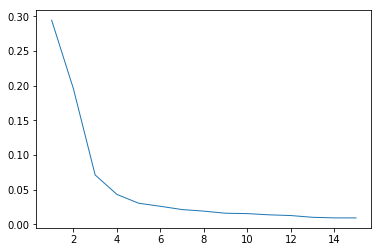

In [196]:
# Looking at the graph of explained variance and looking for the "elbow"
plt.plot(range(1, len(explained_var) + 1), explained_var, lw=1);

In [202]:
# Looking at the cross val score
pca = PCA(n_components=2)
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
model = LinearRegression()
cross_val_score(model, pca.fit_transform(X_train_scaled), y_train, cv=kfolds)

array([0.3165333 , 0.20654625, 0.22945278, 0.10010869, 0.27832791])

In [203]:
# Seeing the score on the validation set
model = LinearRegression()
model.fit(pca.transform(X_train_scaled), y_train)
model.score(pca.transform(X_validate_scaled), y_validate)

0.2758460944586093

#### Neural Net
- Graph has a strange pattern. Higher predicted scores were too low.
- Performed better than past neural nets, but was still not as good as other models.

In [159]:
# Preparing a neural net with all possible features
model_features = data[numeric_columns].dropna(axis=1).columns
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [160]:
# Creating the neural net
model = Sequential()
model.add(Dense(len(model_features), activation='relu', input_dim=len(model_features)))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/2), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/4), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/8), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/16), activation='relu'))
model.add(Dropout(.5))
model.add(Dense(int(len(model_features)/32), activation='relu', kernel_regularizer=regularizers.l2(.01)))
model.add(Dense(1, activation=None))

In [161]:
# Compiling the neural net and setting an early stopping feature
model.compile(loss='mean_squared_error', optimizer='adam')
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=50)

In [162]:
# Fitting the neural net
model.fit(X_train_scaled, y_train, validation_data=(X_validate_scaled, y_validate),epochs=1000,
          callbacks=[early], verbose=0);

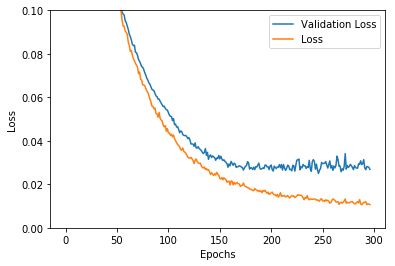

In [163]:
# Plotting the loss over epochs while training
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.plot(model.history.history['loss'], label='Loss')
plt.ylim(0,.1)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend();

In [164]:
# Finding the r2 score on the validation set
r2_score(y_validate, model.predict(X_validate_scaled))

0.1876225567741151

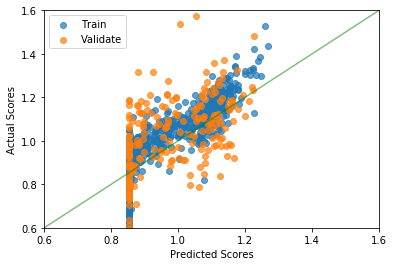

In [165]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, model, axis_max=1.6, axis_min=.6)

#### Linear Regression with My Selected Features
- These features are based on correlations that I saw, features that go into post-up rate, and features that I wanted to experiment with.
- The scores seem similar to the 1 feature model.

In [170]:
# Saving the model features
model_features = ['VERY_OPEN_EFG_PCT', 'OPEN_EFG_PCT', 'CATCH_SHOOT_RATE_WEIGHTED',
                  'TIGHT_EFG_PCT', 'PULL_UP_RATE_WEIGHTED',
                  'POST_TOUCH_RATE_WEIGHTED', 'PLAYER_HEIGHT_INCHES', 'SKINNY', 'AGE', '2015', '2016', '2017']

In [171]:
# Finding the cross validation score
model = LinearRegression()
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(model, X_train[model_features], y_train, cv=kfolds)

array([0.30898976, 0.32931063, 0.38026937, 0.24346835, 0.33610597])

In [172]:
# Checking the validation scores
model.fit(X_train[model_features], y_train)
model.score(X_validate[model_features], y_validate)

0.37736261345212285

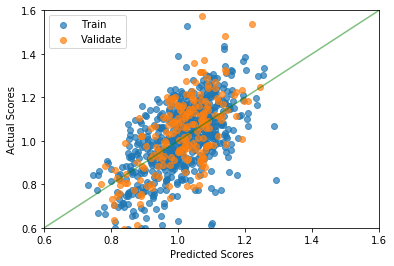

In [173]:
# Plotting the predicted versus actual scores for the training and validation sets
graph_results(X_train[model_features], y_train, X_validate[model_features], y_validate, model, axis_max=1.6,
              axis_min=.6)

#### Regularized Linear Regression with My Selected Features
- These scores are slightly improved compared to the linear regression.
- Drive rate in the current season dominated both of their predictions.

In [174]:
# Scaling the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[model_features])
X_validate_scaled = scaler.transform(X_validate[model_features])

In [175]:
# Testing out ridge regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
ridge_cv = RidgeCV(alphas=np.logspace(-1,3,100), cv=kfolds)
ridge_cv.fit(X_train_scaled, y_train)
ridge = Ridge(alpha=ridge_cv.alpha_)
cross_val_score(ridge, X_train_scaled, y_train, cv=kfolds)

array([0.31889954, 0.33646368, 0.37131541, 0.25016457, 0.33403058])

In [186]:
# Seeing the score on the validation set
ridge.fit(X_train_scaled, y_train)
ridge.score(X_validate_scaled, y_validate)

0.3732121732396071

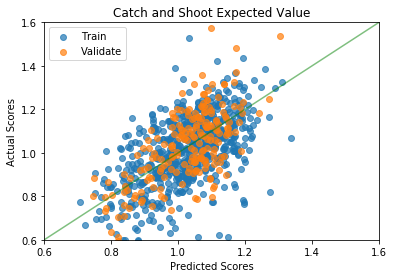

In [177]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, ridge, axis_max=1.6, axis_min=.6)
plt.title('Catch and Shoot Expected Value');

In [178]:
# Testing out lasso regression
kfolds = KFold(n_splits=5, shuffle=True, random_state=42)
lasso_cv = LassoCV(alphas=np.linspace(.01,1,100), cv=kfolds)
lasso_cv.fit(X_train_scaled, y_train)
lasso = Lasso(alpha=lasso_cv.alpha_)
cross_val_score(lasso, X_train_scaled, y_train, cv=kfolds)

/anaconda3/envs/dsi/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0.32449168, 0.31781769, 0.34512093, 0.23005707, 0.30713025])

In [187]:
# Seeing the score on the validation set
lasso.fit(X_train_scaled, y_train)
lasso.score(X_validate_scaled, y_validate)

0.3326565008128213

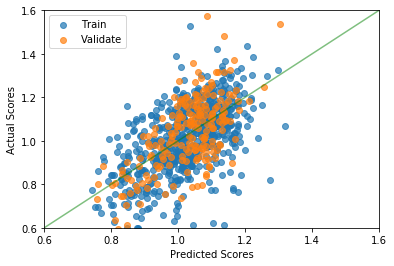

In [180]:
graph_results(X_train_scaled, y_train, X_validate_scaled, y_validate, lasso, axis_max=1.6, axis_min=.6)

In [181]:
# Looking at the selected features
lasso_coefs = pd.DataFrame(lasso.coef_, index=model_features, columns=['LASSO'])
ridge_coefs = pd.DataFrame(ridge.coef_, columns=model_features, index=['RIDGE']).T
pd.concat([lasso_coefs, ridge_coefs], axis=1)

,LASSO,RIDGE
VERY_OPEN_EFG_PCT,0.050614,0.043559
OPEN_EFG_PCT,0.001517,0.011277
CATCH_SHOOT_RATE_WEIGHTED,0.032677,0.035779
TIGHT_EFG_PCT,-0.022020,-0.024484
PULL_UP_RATE_WEIGHTED,0.013616,0.018609
POST_TOUCH_RATE_WEIGHTED,-0.009842,-0.012793
PLAYER_HEIGHT_INCHES,-0.024165,-0.021580
SKINNY,0.013879,0.018949
AGE,0.013285,0.019672
2015,0.000000,0.012851


#### Final scores (Ridge)
- The r2 score on the test set was lower than the better of the cross validation scores.
- There was a 6.5 percent improvement in the rmse compared to the baseline using the test set.

In [188]:
# Linear model score on test data
X_test_scaled = scaler.transform(X_test[model_features])
r2_score(y_test, ridge.predict(X_test_scaled))

0.23208389397219875

In [190]:
# Root mean squared error
rmse = mean_squared_error(y_test, ridge.predict(X_test_scaled)) ** .5
rmse

0.13420849640224156

In [191]:
# The score if the prediction was just the value from the current year 
baseline = mean_squared_error(y_test, X_test['CATCH_SHOOT_EV']) ** .5
baseline

0.15859050213812

In [192]:
# Looking at the percent improvement (test set)
1 - rmse/baseline

0.15374190387923492

#### Looking to correct the undervaluing/overvaluing problem (Future)

In [193]:
# Creating a training set
train = pd.merge(X_train, y_train, left_index=True, right_index=True)
train['PREDICTED_CATCH_SHOOT_EV'] = ridge.predict(X_train_scaled)

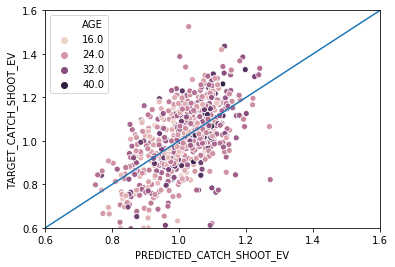

In [194]:
sns.scatterplot('PREDICTED_CATCH_SHOOT_EV', 'TARGET_CATCH_SHOOT_EV', data=train, hue='AGE')
plt.plot([0,1.6], [0,1.6])
plt.xlim(.6, 1.6)
plt.ylim(.6, 1.6);